# 在车辆数据集上实现 ResNet

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils import data

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1):
        super(ResidualBlock,self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
    def forward(self,x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=3):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [4]:
def ResNet18():
    return ResNet(ResidualBlock)

In [5]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output,1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss,acc

In [6]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [7]:
path_train = r'./车辆分类数据集/train/'  # 路径
path_test = r'./车辆分类数据集/test/'  # 路径

train = torchvision.datasets.ImageFolder(path_train, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))
test =torchvision.datasets.ImageFolder(path_test, transform=transforms.Compose(
    [transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()]))

In [8]:
classes = ('bus','car','truck')
num_classes = 3
epochs = 25
lr = 0.001
batch_size = 256
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [9]:
net = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, data_loader=train_loader,device=device)
    test_loss, test_acc = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
          f"train_acc:{train_acc:.5f}\t"
          f"test_loss:{test_loss:.5f}\t test_acc:{test_acc:.5f}")

epoch:1	 train_loss:1.59402	train_acc:0.59724	test_loss:3.51206	 test_acc:0.26471
epoch:2	 train_loss:0.48255	train_acc:0.83410	test_loss:4.22584	 test_acc:0.26471
epoch:3	 train_loss:0.30722	train_acc:0.87926	test_loss:6.00165	 test_acc:0.26471
epoch:4	 train_loss:0.24896	train_acc:0.91982	test_loss:6.67203	 test_acc:0.26471
epoch:5	 train_loss:0.20970	train_acc:0.92995	test_loss:5.06786	 test_acc:0.26838
epoch:6	 train_loss:0.16578	train_acc:0.94378	test_loss:4.35360	 test_acc:0.31250
epoch:7	 train_loss:0.16720	train_acc:0.94101	test_loss:2.63796	 test_acc:0.53309
epoch:8	 train_loss:0.14909	train_acc:0.94747	test_loss:1.30460	 test_acc:0.71691
epoch:9	 train_loss:0.14301	train_acc:0.95853	test_loss:0.67248	 test_acc:0.79044
epoch:10	 train_loss:0.12478	train_acc:0.95576	test_loss:0.21359	 test_acc:0.87132
epoch:11	 train_loss:0.09004	train_acc:0.96959	test_loss:0.54333	 test_acc:0.88603
epoch:12	 train_loss:0.09340	train_acc:0.96959	test_loss:0.26926	 test_acc:0.87132
epoch:13	 tra

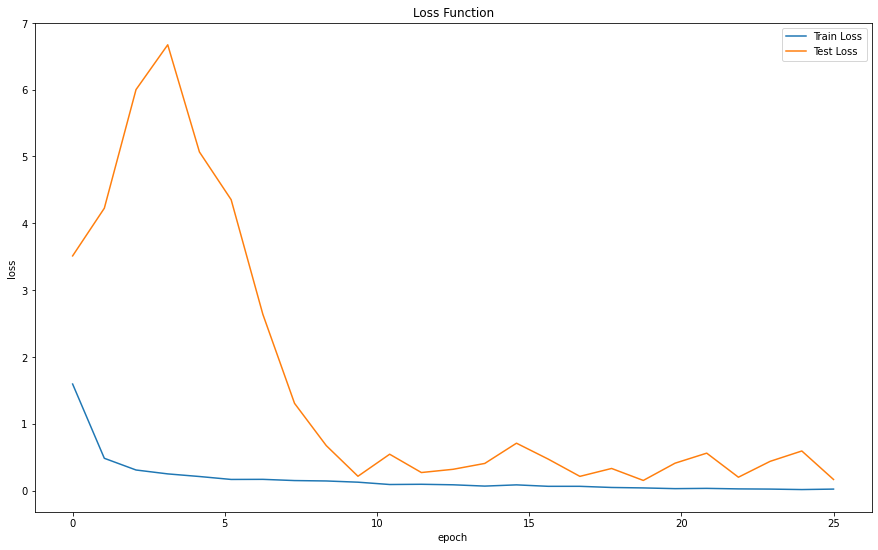

In [10]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

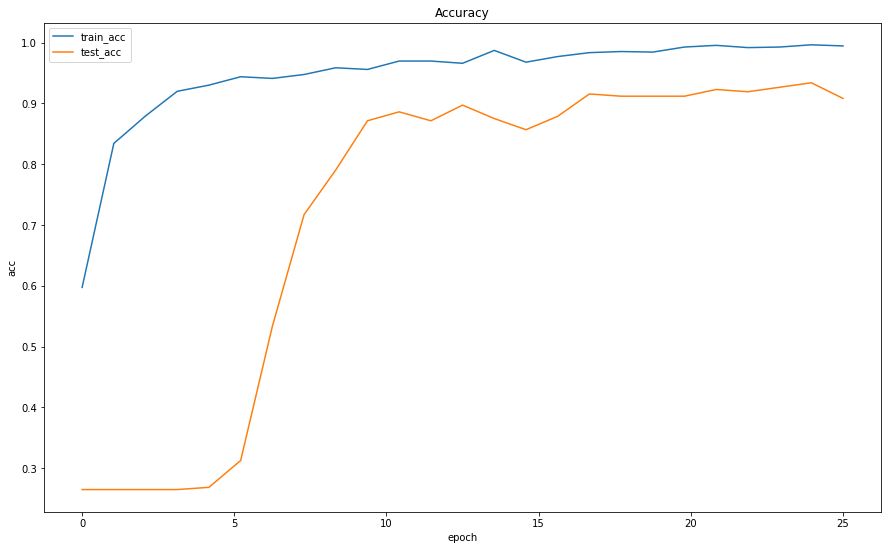

In [11]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [12]:
end = time.time()
print(end-begin)

1348.1250112056732


# 在去雾数据集上实现 ResNet

In [31]:
import os
from os import listdir
from os.path import join
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils import data

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1):
        super(ResidualBlock,self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
    def forward(self,x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [52]:
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=3):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.deconv1 = nn.Sequential(
                    nn.ConvTranspose2d(512, 256, kernel_size=12, stride=8, padding=2, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=12, stride=8, padding=2, bias=False),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.deconv2 = nn.Sequential(
                    nn.ConvTranspose2d(128, 64, kernel_size=12, stride=8, padding=2, bias=False),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
        )
        self.refine = nn.Sequential(
                    nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(3),
                    nn.ReLU()
        )

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.deconv1(out)
        out = self.conv2(out)
        out = self.deconv2(out)
        out = self.refine(out)
        return out

In [53]:
def ResNet18():
    return ResNet(ResidualBlock)

In [54]:
def cal_ssim(img_pre,img_gt):
    img_gt_u = np.mean(img_gt)
    img_pre_u = np.mean(img_pre)
    img_gt_var = np.var(img_gt)
    img_pre_var = np.var(img_pre)
    img_gt_std = np.sqrt(img_gt_var)
    img_pre_std = np.sqrt(img_pre_var)
    c1 = np.square(0.01 * 7)
    c2 = np.square(0.03 * 7)
    ssim_0 = (2 * img_gt_u * img_pre_u + c1) * (2 * img_gt_std * img_pre_std + c2)
    denom = (img_gt_u ** 2 + img_pre_u ** 2 + c1) * (img_gt_var + img_pre_var + c2)
    ssim = ssim_0 / denom
    return ssim

In [55]:
def train_epoch(net,data_loader,device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    for batch_idx,(data,target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).float()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += cal_ssim(output.detach().numpy(),target.detach().numpy())
        sample_num += 1 
    loss = total_loss / train_batch_num
    ssim = correct / sample_num
    return loss,ssim

In [56]:
def test_epoch(net,data_loader,device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).float()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            correct += cal_ssim(output.detach().numpy(),target.detach().numpy())
            sample_num += 1 
    loss = total_loss / test_batch_num
    ssim = correct / sample_num
    return loss,ssim

In [28]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

In [29]:
def load_img(filepath):
    img = Image.open(filepath)
    return img

In [32]:
path_train = r'./去雾数据集/train/'  # 路径
path_test = r'./去雾数据集/test/'  # 路径


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, gt_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
        self.gt_dir = gt_dir
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])

        _, file = os.path.split(self.image_filenames[index])  # dir,filename

        target = load_img(os.path.join(self.gt_dir, os.path.splitext(file)[0] + '.jpg'))
        
        if self.target_transform:
            target = self.target_transform(target)

        if self.input_transform:
            input = self.input_transform(input)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

def input_transform():
    return transforms.Compose([transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()])

def target_transform():
    return transforms.Compose([transforms.Resize((32, 32)), transforms.CenterCrop(32), transforms.ToTensor()])

train = DatasetFromFolder(path_train+'input/', path_train+'gt/',
                             input_transform=input_transform(),
                             target_transform=target_transform())
test = DatasetFromFolder(path_test+'input/', path_test+'gt/',
                             input_transform=input_transform(),
                             target_transform=target_transform())

In [57]:
epochs = 100
lr = 0.0001
batch_size = 512
device=torch.device("cpu")
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=0)

In [58]:
net = ResNet18().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(),lr=lr)
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
begin = time.time()
for epoch in range(epochs):
    train_loss,train_ssim = train_epoch(net, data_loader=train_loader,device=device)
    test_loss,test_ssim = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_ssim)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_ssim)
    if (epoch+1)%20==0:
        print(f"epoch:{epoch+1}\t train_loss:{train_loss:.5f}\t"
              f"train_ssim:{train_ssim:.5f}\t"
              f"test_loss:{test_loss:.5f}\t" f"test_ssim:{test_ssim:.5f}\t")

epoch:20	 train_loss:0.18317	train_ssim:0.97097	test_loss:0.25480	test_ssim:0.57370	
epoch:40	 train_loss:0.14253	train_ssim:0.98065	test_loss:0.19108	test_ssim:0.87176	
epoch:60	 train_loss:0.12335	train_ssim:0.98414	test_loss:0.14685	test_ssim:0.97052	
epoch:80	 train_loss:0.11086	train_ssim:0.98666	test_loss:0.12885	test_ssim:0.98592	
epoch:100	 train_loss:0.10311	train_ssim:0.98982	test_loss:0.12287	test_ssim:0.98935	


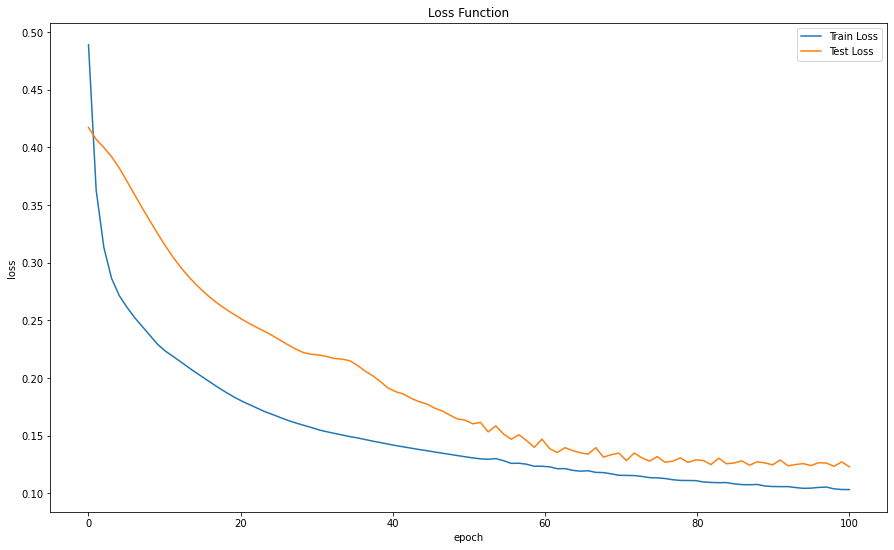

In [59]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    x_loss = np.linspace(0, len(train_loss_list), len(train_loss_list))
    plt.plot(x_loss, train_loss_list, label=u'Train Loss', linewidth=1.5)
    plt.plot(x_loss, test_loss_list, label=u'Test Loss', linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Loss_Curve()

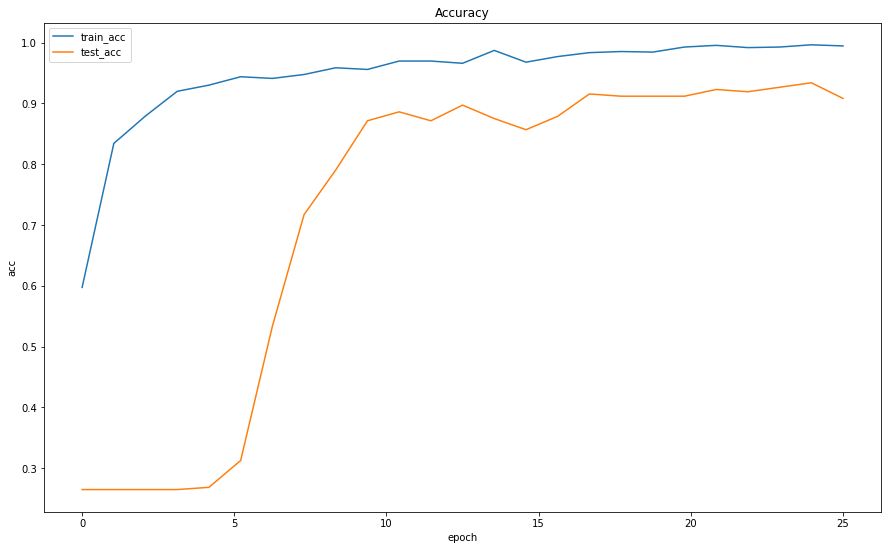

In [60]:
def Draw_Acc_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.title("Accuracy")
    x_acc = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.plot(x_acc, train_acc_list, label="train_acc", linewidth=1.5)
    plt.plot(x_acc, test_acc_list, label="test_acc", linewidth=1.5)
    plt.legend()
    plt.show()
Draw_Acc_Curve()

In [61]:
end = time.time()
print(end-begin)

4260.321630001068
